# Import packages

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

import torch
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd

from IPython import display
import time

from math import *

import scipy

In [2]:
plt.rcParams.update({'font.family': 'Arial'})

SMALL_SIZE = 9
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Data loading

In [3]:
from sklearn.preprocessing import LabelEncoder

alldata = pd.read_csv("pbdb_data_lineheader_idresogenus.csv")
#genus level data

alldata = alldata[pd.notnull(alldata["accepted_name"])]
alldata = alldata[pd.notnull(alldata["accepted_rank"])]
#exclude data without an accepted name or rank
#alldata = alldata[alldata["accepted_rank"] == "species"]
#exclude data without an accepted species rank
alldata = alldata[alldata["phylum"] != "NO_PHYLUM_SPECIFIED"]
#exclude data without an accepted phylum

In [4]:
print(alldata.head())

   occurrence_no record_type  reid_no flags  collection_no  \
0              1         occ      NaN   NaN              1   
1              2         occ      NaN   NaN              1   
2              3         occ      NaN   NaN              1   
3              4         occ      NaN   NaN              2   
4              5         occ      NaN   NaN              3   

             identified_name identified_rank  identified_no difference  \
0  Australosutura llanoensis         species         349412        NaN   
1  Carbonocoryphe planucauda         species         349526        NaN   
2       Thigriffides roundyi         species         349420        NaN   
3   Pudoproetus chappelensis         species         349411        NaN   
4   Pudoproetus chappelensis         species         349411        NaN   

               accepted_name  ... min_ma  reference_no      phylum      class  \
0  Australosutura llanoensis  ...  345.3             1  Arthropoda  Trilobita   
1  Carbonocoryphe pl

In [54]:
alldata['accepted_rank']

0          species
1          species
2          species
3          species
4          species
            ...   
1273249      genus
1273250      genus
1273251      genus
1273252      genus
1273253    species
Name: accepted_rank, Length: 1241535, dtype: object

In [5]:
fnames = np.array(alldata["genus"]).astype(np.str)
#genus level analysis
phylum = np.array(alldata["phylum"])

ple = LabelEncoder()
phyla = ple.fit_transform(phylum)

le = LabelEncoder()
ids = le.fit_transform(fnames)

In [6]:
print(le.classes_.shape[0])

61882


In [7]:
mnma = np.array(alldata["min_ma"])
mxma = np.array(alldata["max_ma"])

In [8]:
species_mnma = np.zeros(le.classes_.shape[0]) + 5000
species_mxma = np.zeros(le.classes_.shape[0]) - 5000
species_phylum = np.zeros(le.classes_.shape[0]).astype(np.int32)

for i in range(le.classes_.shape[0]):
    if i%5000 == 0:
        print(i)
    loc = np.where(ids==i)[0]
    species_mnma[i] = np.min(mnma[loc])
    species_mxma[i] = np.max(mxma[loc])
    if len(loc)>0:
        species_phylum[i] = phyla[loc[0]]

0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000


In [9]:
species_mnma.shape

(61882,)

In [10]:
# Species/genus intervals (rather than occurrence intervals)
def getIntervalIndex(tmin, tmax):
    match = ((species_mnma>=tmin)*(species_mnma<=tmax) + (species_mxma>=tmin)*(species_mxma<=tmax) + (tmin>=species_mnma)*(tmin<=species_mxma) + (tmax>=species_mnma)*(tmax<=species_mxma) > 0)
    
    return np.where(match)

def getInterval(tmin, tmax):
    match = ((species_mnma>=tmin)*(species_mnma<=tmax) + (species_mxma>=tmin)*(species_mxma<=tmax) + (tmin>=species_mnma)*(tmin<=species_mxma) + (tmax>=species_mnma)*(tmax<=species_mxma) > 0)

    return species_mnma[match], species_mxma[match]

In [12]:
Swartpuntiaindex=np.where(le.classes_=='Swartpuntia')[0]
print(Swartpuntiaindex)

[55244]


In [13]:
print(species_mnma[Swartpuntiaindex])
print(species_mxma[Swartpuntiaindex])

[513.]
[635.]


# Count fossil types

In [17]:
xs = np.arange(600)
#1 My time windows
ys = np.zeros(600)
ys2 = np.zeros(600)
nboth = np.zeros(600)
nrangethroughs = np.zeros(600)
nexitonly = np.zeros(600)
nenteronly = np.zeros(600)

counts = np.zeros(600)

for i in range(xs.shape[0]):
    x = xs[i]
    sids = getIntervalIndex(x,x+1)[0]
    cmin = species_mnma[sids]
    cmax = species_mxma[sids]
    
    leaving = sids[np.abs(cmin-x-0.49)<=0.5]
    #taxon min Ma is within 1 My of time x
    #The taxon exits the fossil record within 1 My of this time
    entering = sids[np.abs(cmax-x-0.49)<=0.5]
    #taxon max Ma is within 1 My of time x
    #The taxon enters the fossil record within 1 My of this time
    
    both = sids[np.logical_and(np.abs(cmin-x-0.49)<=0.5,np.abs(cmax-x-0.49)<=0.5)]
    #species which enter and leave within the same time window 
    #'confined to interval' Foote 2000
    
    rangethroughs = sids[np.logical_and(np.abs(cmin-x-0.49)>0.5,np.abs(cmax-x-0.49)>0.5)]
    #species occurring within the time window which do not enter or leave within the same time window
    #'both boundaries crossed' Foote 2000
    
    exitonly = sids[np.logical_and(np.abs(cmin-x-0.49)<=0.5,np.abs(cmax-x-0.49)>0.5)]
    #species which go extinct in the time window but do not originate in the time window
    #'only bottom boundary crossed' Foote 2000
    
    enteronly = sids[np.logical_and(np.abs(cmin-x-0.49)>0.5,np.abs(cmax-x-0.49)<=0.5)]
    #species which originate in the time window but do not go extinct in the time window
    #'only top boundary crossed' Foote 2000
        
    ys[i] = np.sum(np.abs(cmin-x-0.49)<=0.5)
    #extinctions
    ys2[i] = np.sum(np.abs(cmax-x-0.49)<=0.5)
    #originations
    
    nboth[i] = both.shape[0]
    nrangethroughs[i] = rangethroughs.shape[0]
    nexitonly[i] = exitonly.shape[0]
    nenteronly[i]=enteronly.shape[0]
    
    counts[i] = cmin.shape[0]

In [40]:
xs[1]

1

# Statistics

In [18]:
print(nboth[541])

0.0


In [19]:
print(nrangethroughs[541])
print((nrangethroughs[541]/counts[541])*100)

19.0
3.5580524344569286


In [20]:
print(nexitonly[541])
print((nexitonly[541]/counts[541])*100)

55.0
10.299625468164795


In [21]:
print(nenteronly[541])
print((nenteronly[541]/counts[541])*100)

460.0
86.14232209737828


In [22]:
counts[541]

534.0

In [42]:
countcheck=nboth+nrangethroughs+nexitonly+nenteronly

In [24]:
countcheck[541]

534.0

In [47]:
np.all(counts==countcheck)==True
#The types of all the fossil taxa observed in a time interval sum to the total number of taxa observed in the time interval

True

In [25]:
propsurvivors=nrangethroughs/(nexitonly+nrangethroughs)
#rangethroughs/extinctions only

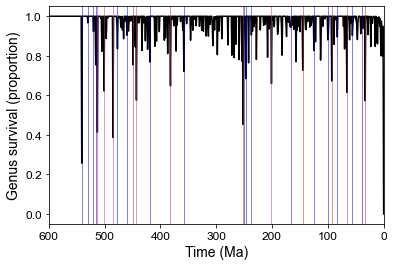

In [26]:
plt.plot(propsurvivors,color='k')
plt.xlabel("Time (Ma)")
plt.ylabel("Genus survival (proportion)")


fig = plt.gcf()

axes = plt.gca()

axes.set_xlim([600, 0])  
#axes.set_ylim([0,1])

#C1272D red
#0000FF blue
#CC3399 magenta

#genus times:
matplotlib.pyplot.axvline(x=0, ymin=0, ymax=1,color='#CC3399', linewidth=0.5)
matplotlib.pyplot.axvline(x=33, ymin=0, ymax=1,color='#C1272D', linewidth=0.5)
matplotlib.pyplot.axvline(x=38, ymin=0, ymax=1,color='#0000FF', linewidth=0.5)
matplotlib.pyplot.axvline(x=56, ymin=0, ymax=1,color='#0000FF', linewidth=0.5)
matplotlib.pyplot.axvline(x=66, ymin=0, ymax=1,color='#C1272D', linewidth=0.5)
matplotlib.pyplot.axvline(x=83, ymin=0, ymax=1,color='#0000FF', linewidth=0.5)
matplotlib.pyplot.axvline(x=93, ymin=0, ymax=1,color='#C1272D', linewidth=0.5)
matplotlib.pyplot.axvline(x=99, ymin=0, ymax=1,color='#0000FF', linewidth=0.5)
matplotlib.pyplot.axvline(x=125, ymin=0, ymax=1,color='#0000FF', linewidth=0.5)
matplotlib.pyplot.axvline(x=145, ymin=0, ymax=1,color='#C1272D', linewidth=0.5)
matplotlib.pyplot.axvline(x=166, ymin=0, ymax=1,color='#0000FF', linewidth=0.5)
matplotlib.pyplot.axvline(x=201, ymin=0, ymax=1,color='#CC3399', linewidth=0.5)
matplotlib.pyplot.axvline(x=237, ymin=0, ymax=1,color='#0000FF', linewidth=0.5)
matplotlib.pyplot.axvline(x=247, ymin=0, ymax=1,color='#0000FF', linewidth=0.5)
matplotlib.pyplot.axvline(x=251, ymin=0, ymax=1,color='#0000FF', linewidth=0.5)
matplotlib.pyplot.axvline(x=252, ymin=0, ymax=1,color='#C1272D', linewidth=0.5)
matplotlib.pyplot.axvline(x=358, ymin=0, ymax=1,color='#0000FF', linewidth=0.5)
matplotlib.pyplot.axvline(x=382, ymin=0, ymax=1,color='#C1272D', linewidth=0.5)
matplotlib.pyplot.axvline(x=419, ymin=0, ymax=1,color='#0000FF', linewidth=0.5)
matplotlib.pyplot.axvline(x=443, ymin=0, ymax=1,color='#CC3399', linewidth=0.5)
matplotlib.pyplot.axvline(x=449, ymin=0, ymax=1,color='#C1272D', linewidth=0.5)
matplotlib.pyplot.axvline(x=460, ymin=0, ymax=1,color='#0000FF', linewidth=0.5)
matplotlib.pyplot.axvline(x=478, ymin=0, ymax=1,color='#0000FF', linewidth=0.5)
matplotlib.pyplot.axvline(x=485, ymin=0, ymax=1,color='#CC3399', linewidth=0.5)
matplotlib.pyplot.axvline(x=501, ymin=0, ymax=1,color='#CC3399', linewidth=0.5)
matplotlib.pyplot.axvline(x=513, ymin=0, ymax=1,color='#CC3399', linewidth=0.5)
matplotlib.pyplot.axvline(x=516, ymin=0, ymax=1,color='#0000FF', linewidth=0.5)
matplotlib.pyplot.axvline(x=520, ymin=0, ymax=1,color='#0000FF', linewidth=0.5)
matplotlib.pyplot.axvline(x=530, ymin=0, ymax=1,color='#0000FF', linewidth=0.5)
matplotlib.pyplot.axvline(x=541, ymin=0, ymax=1,color='#0000FF', linewidth=0.5)


fig.savefig('SurvivorPropGenus.pdf', format='pdf', dpi=1200)
fig.savefig('SurvivorPropGenus.svg', format='svg', dpi=1200)
fig.savefig('SurvivorPropGenus.jpg', format='jpg', dpi=72)

# Plot threshold events

In [27]:
threshold=0.22
threshold2=0.21
extinctions = xs[ys>threshold*counts]
entries = xs[ys2>threshold*counts]
#was 0.2

# Extreme events
extinctions2 = xs[ys>threshold2*counts]
entries2 = xs[ys2>threshold2*counts]
#was 0.4

In [28]:
print(extinctions.shape, extinctions2.shape)
print(entries.shape, entries2.shape)

(13,) (14,)
(23,) (23,)


In [29]:
print(entries)
print(extinctions)

[  0  38  56  83  99 125 166 201 237 247 251 358 419 443 460 478 485 501
 513 516 520 530 541]
[  0  33  66  93 145 201 252 382 443 449 485 501 513]


In [30]:
joint = []

for x in extinctions:
    if x in entries:
        joint.append(x)
        
joint = np.array(joint)

In [31]:
union = np.unique(np.concatenate([extinctions, entries],axis=0)).astype(np.int32)
union2 = np.unique(np.concatenate([extinctions2, entries2],axis=0)).astype(np.int32)

In [32]:
print("Radiations: %d" % entries.shape[0])
print("Extinctions: %d" % extinctions.shape[0])
print("Intersection: %d" % joint.shape[0])
print("Union: %d" % union.shape[0])

Radiations: 23
Extinctions: 13
Intersection: 6
Union: 30


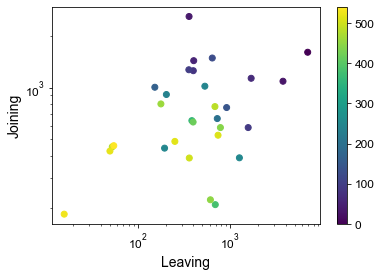

In [33]:
extnumber = ys[union]
entnumber = ys2[union]

plt.scatter(extnumber, entnumber, c=xs[union])
plt.colorbar()
plt.xlabel("Leaving")
plt.ylabel("Joining")
plt.xscale("log")
plt.yscale("log")
#plt.plot([1e3,1e5],[1e3,1e5],'k--')
plt.show()

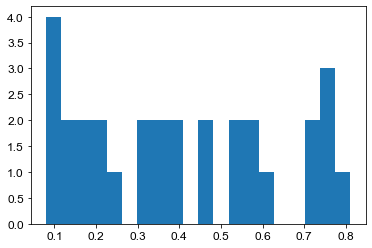

In [34]:
plt.hist(extnumber/(extnumber+entnumber), 20)
plt.show()

In [35]:
np.mean(extnumber/(extnumber+entnumber))

0.40300395334817457

In [36]:
rel_ext = extnumber/counts[union]
rel_ent = entnumber/counts[union]
sampletime=xs[union]
print(rel_ext.shape)

(30,)


In [37]:
print(union.shape[0])
print(union[union.shape[0]-1])
print(rel_ext[union.shape[0]-1])
print(rel_ent[union.shape[0]-1])

30
541
0.10299625468164794
0.8614232209737828


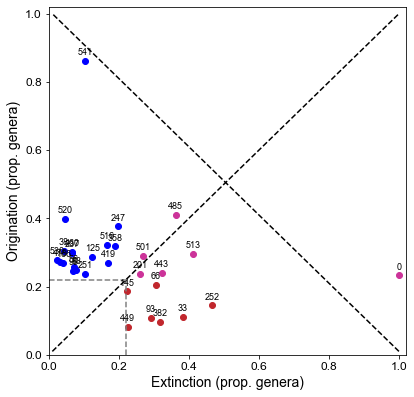

In [38]:

for i in range(union.shape[0]):
    
    if np.logical_and(rel_ext[i]>threshold,rel_ent[i]>threshold):
        plt.scatter(rel_ext[i], rel_ent[i],color='#CC3399')#magenta
   
    if np.logical_and(rel_ext[i]<threshold,rel_ent[i]>threshold):
        plt.scatter(rel_ext[i], rel_ent[i],color='#0000FF')#blue
    
    if np.logical_and(rel_ext[i]>threshold,rel_ent[i]<threshold):
        plt.scatter(rel_ext[i], rel_ent[i],color='#C1272D')#red
    
    
#plt.xscale("log")
#plt.yscale("log")
#plt.xlim(0,1.5)
#plt.ylim(0,1.5)
plt.plot([1e-2,1],[1e-2,1],'k--')
plt.plot([1,1e-2],[1e-2,1],'k--')

plt.plot([0,threshold],[threshold,threshold],color='gray', linestyle='dashed')
plt.plot([threshold,threshold],[0,threshold],color='gray', linestyle='dashed')

axes = plt.gca()
axes.set_xlim(0,1.02)  
axes.set_ylim(0,1.02) 

#plt.gcf().set_size_inches((3.1,3.1))
plt.gcf().set_size_inches((6.4,6.4))
#plt.gcf().set_size_inches((12,12))
fig = plt.gcf()

plt.xlabel("Extinction (prop. genera)")
plt.ylabel("Origination (prop. genera)")

for i in range(len(sampletime)):
    x=rel_ext[i]
    y=rel_ent[i]
    label = "{:.0f}".format(sampletime[i])

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,6), # distance from text to points (x,y)
                 ha='center', # horizontal alignment can be left, right or center
                 fontsize=9)
    
fig.savefig('EnteringExitingGenus22.pdf', format='pdf', dpi=1200)
fig.savefig('EnteringExitingGenus22.svg', format='svg', dpi=1200)
fig.savefig('EnteringExitingGenus22.jpg', format='jpg', dpi=72)

plt.show()

# Drill plots

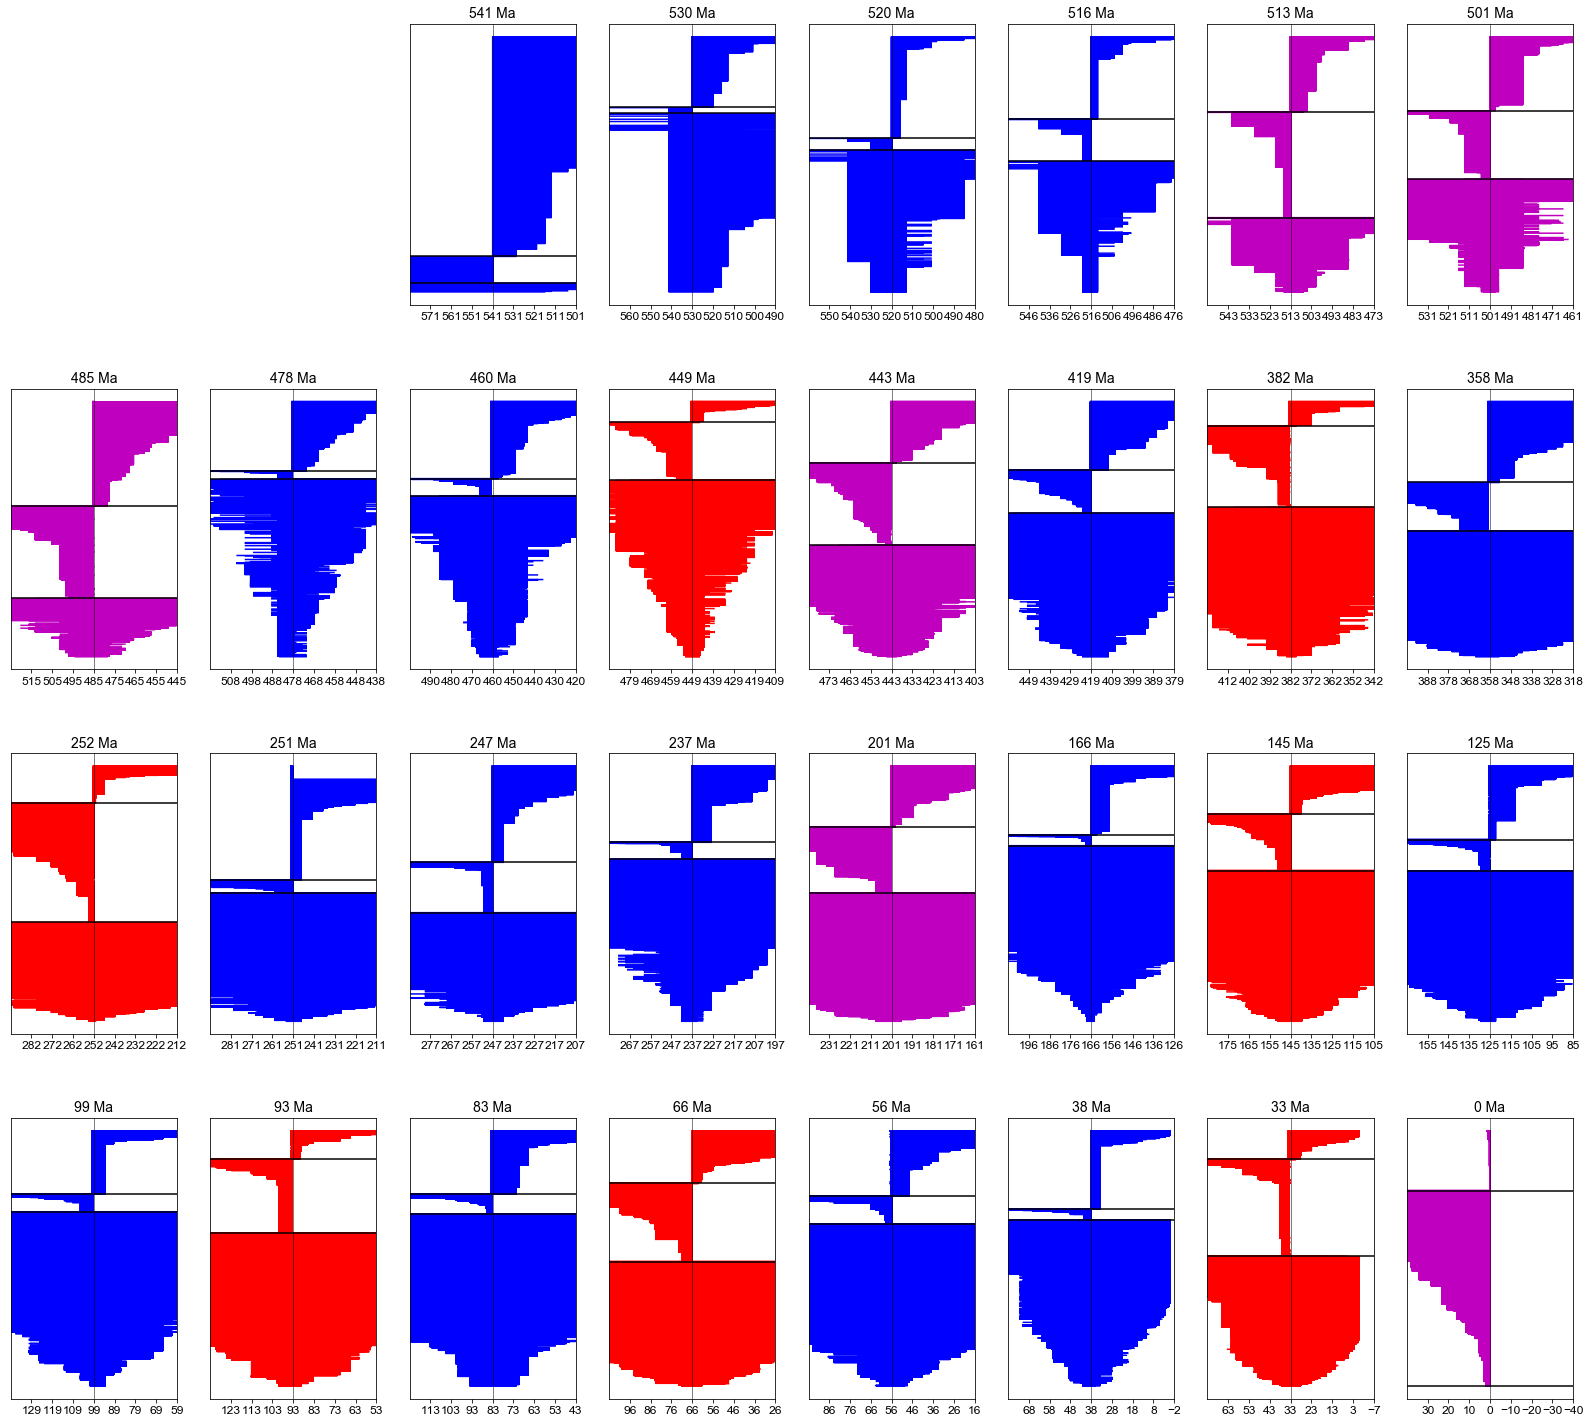

In [117]:
reverse=np.flip(np.arange(union.shape[0]))

for j in range(union.shape[0]):
    i=reverse[j]
    plt.subplot(5,8,j+3)
    
    #plt.tight_layout() # Or equivalently,  "plt.tight_layout()"
    plt.subplots_adjust(hspace=0.3)
    
    mins, maxes = getInterval(union[i], union[i]+1)
    
    plt.title("%d Ma" % union[i])
    #idx = np.argsort(maxes + 1e-4 * mins)
    idx = np.argsort(1e-6 * np.maximum(np.abs(maxes-union[i]), np.abs(mins-union[i])) + 2*(np.abs(maxes-union[i]-0.49)<=0.75) + 1*(np.abs(mins-union[i]-0.49)<=0.75))

    mins = mins[idx]
    maxes = maxes[idx]

    y1 = np.where(np.abs(maxes-union[i]-0.49)<=0.75)[0]
    if len(y1)>0:
        y1 = y1[0]
    else:
        y1 = 0
        
    y2 = np.where(np.abs(mins-union[i]-0.49)<=0.75)[0]
    if len(y2)>0:
        y2 = y2[0]
    else:
        y2 = 0
        
    coords = np.concatenate([mins[:,np.newaxis], maxes[:,np.newaxis], np.nan*maxes[:,np.newaxis]], axis=1)
    coords = coords.reshape((coords.shape[0]*coords.shape[1],1))
    coords = np.concatenate([coords, np.arange(coords.shape[0])[:,np.newaxis]//3],axis=1)

    if union[i] in extinctions and union[i] not in entries:
        plt.plot(coords[:,0], coords[:,1], 'r')
    elif union[i] in entries and union[i] not in extinctions:
        plt.plot(coords[:,0], coords[:,1], 'b')
    else:
        plt.plot(coords[:,0], coords[:,1], 'm')
    
    plt.xlim(union[i]+40, union[i]-40)#np.max(maxes), np.min(mins))
    plt.yticks([])
    plt.xticks(np.arange(union[i]-40, union[i]+40, 10))#np.min(mins), np.max(maxes), 10))
    #plt.xticks(np.arange(np.min(mins), np.max(maxes), 10))
    plt.axvline(x=union[i], ymin=0, ymax=180000, color='k', linewidth=0.5)
    plt.axhline(y1,0,600,color='k')
    plt.axhline(y2,0,600,color='k')
plt.gcf().set_size_inches((28,32))
fig = plt.gcf()
fig.savefig('DrillPlotsGenus22.pdf', format='pdf', dpi=300)
fig.savefig('DrillPlotsGenus22.svg', format='svg', dpi=300)
fig.savefig('DrillPlotsGenus22.jpg', format='jpg', dpi=300)
plt.show()    

In [87]:
print(union)
print(reverse)

[  0  33  38  56  66  83  93  99 125 145 166 201 237 247 251 252 358 382
 419 443 449 460 478 485 501 513 516 520 530 541]
[29 28 27 26 25 24 23 22 21 20 19 18 17 16 15 14 13 12 11 10  9  8  7  6
  5  4  3  2  1  0]


In [31]:
print(propsurvivors[union])

[0.         0.57185698 0.93895596 0.90331094 0.61454047 0.895
 0.67252196 0.90775194 0.82632293 0.7264574  0.94362564 0.65930451
 0.90485075 0.68408551 0.86401674 0.45328118 0.72121651 0.64741952
 0.76824285 0.57552788 0.7539267  0.90409483 0.95623452 0.38724169
 0.62198953 0.41349206 0.75414634 0.92272025 0.96659708 0.25675676]


In [32]:
percentsurvivors=propsurvivors*100

In [33]:
print(percentsurvivors[541])

25.675675675675674


In [36]:
print(percentsurvivors[485])

38.72416891284816


In [35]:
print(percentsurvivors[513])

41.34920634920635


In [34]:
print(percentsurvivors[252])

45.32811820947414
